# Imports

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import zipfile
import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from datetime import datetime
import wandb
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import copy

random_state = 2137
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Define all parameters here! To load network from the checkpoint, define the patch here, and look at the section on the botton of the notebook 

In [2]:
passed_config = {
        'last_checkpoint_path': None,
        'model': 'ResNet',
        'optimizer': 'sgd',
        'learning_rate' : 0.02,
        'batch_size': 64,
    }

In [3]:
sweep_config = {
    'method': 'bayes',
    'name': 'final_tuning_InceptionV3',
    "metric": {"goal": "minimize", "name": "validation_loss_epoch"},
    'parameters': {
        'model': {'values': ['ResNet101']},
        'optimizer': {'values': ['sgd', 'adam']},
        'learning_rate': {'min': 0.0001, 'max': 0.07},
        'batch_size': {'values': [32, 64]},
    }
}

In [4]:
os.environ["WANDB_API_KEY"] = 'put here wandb api key'
os.environ["WANDB_MODE"] = "disabled"

# Initialising the project on wandb

In [5]:
def initialize_wandb(config = None, config_info = None):
    current_time = datetime.now().strftime("%m-%d_%H:%M")
    if config == None:
        run_name = f"tuning_{current_time}"
        wandb.init()
    else:
        run_name = f"{current_time}_{config_info}"
        wandb.init(project='cats&dogs_ML&DL_project', save_code=True, config = config, name = run_name)
    return

# Parameters

In [6]:
class configuration:
    def __init__(self, model, model_transforms, config=None):
        self.model = model
        self.initilaized_with_custom_configuration = True
        if config == None:
            self.initilaized_with_custom_configuration = False
            config = wandb.config
            self.batch_size = config.batch_size
            self.init_learning_rate = config.learning_rate
            self.optimizer_name = config.optimizer
        else:
            self.last_checkpoint_path = config['last_checkpoint_path']
            self.init_learning_rate = config['learning_rate']
            self.optimizer_name = config['optimizer']
            self.batch_size = config['batch_size']
        
        self.optimizer = self.initialize_optimizer()
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=3, verbose=True, min_lr=self.init_learning_rate/32, factor=0.5)
        self.criterion = nn.CrossEntropyLoss()
        self.test_transforms = model_transforms
        # combine with some basic transforms
        self.custom_transforms = get_costum_transforms()
        self.train_transforms = transforms.Compose([self.custom_transforms,model_transforms])
        
    def initialize_optimizer(self):
        if self.optimizer_name == 'sgd':
            optimizer = optim.SGD(self.model.parameters(), lr=self.init_learning_rate, momentum=0.9)
        elif self.optimizer_name == 'adam':
            optimizer = optim.Adam(self.model.parameters(), lr=self.init_learning_rate)
        else:
            print("Unsupported optimizer:")
            raise ValueError(f"Unsupported optimizer: {optimizer_name}")
        return optimizer
    
    def get_configuration_info(self):
        info = f"{type(self.model).__name__}_"
        info += f"{type(self.optimizer).__name__}_"
        info += f"Batch={self.batch_size}_"
        info += f"lr={self.optimizer.param_groups[0]['lr']}"
        return info
    def get_configuration_dictionary(self):
        configuration_info = {
            'model_type': type(self.model).__name__,
            'criterion': str(self.criterion),
            'optimizer': type(self.optimizer).__name__,
            'batch_size': self.batch_size,
            'scheduler': type(self.scheduler).__name__,
            'optimizer_params': {
                'initial_lr': self.optimizer.param_groups[0]['lr']
            },
            'scheduler_params': {
                'min_lr': self.scheduler.min_lrs,
                'patience': self.scheduler.patience,
                'factor': self.scheduler.factor
            },
            'custom_transforms': [str(transform) for transform in self.custom_transforms.transforms] if self.custom_transforms else None
        }

        return configuration_info

# loading datasets

In [7]:
#reading csv
annotations = pd.read_csv('../input/cats-and-dogs-breeds-classification-oxford-dataset/annotations/annotations/list.txt')

#The first 4 rows consists of the information about breeds
#Reading the data after 5th row
annotations = annotations.loc[5:,]

#Processing the columns
annotations[['CLASS-ID','SPECIES','BREED','ID']] = annotations['#Image CLASS-ID SPECIES BREED ID'].str.split(expand=True) 

#Dropping unnecessary columns
annotations = annotations.drop('#Image CLASS-ID SPECIES BREED ID',axis=1)

#renaming the columns
annotations = annotations.rename(columns={"CLASS-ID": "image", "SPECIES": "CLASS-ID", 'BREED' : "SPECIES", "ID":"BREED ID"})


#converting the object type to int type
annotations[["CLASS-ID","SPECIES","BREED ID"]] = annotations[["CLASS-ID","SPECIES","BREED ID"]].astype(int)

### RUN THIS CELL ONLY ONCE!!!

In [8]:
# adding the extension to image so it can be used to access the real image
annotations['image'] = annotations['image'].apply(lambda x : str(x)+'.jpg')
annotations = annotations.reset_index()
annotations = annotations.drop('index',axis=1)

#Extracting the classname/breed of the animal
annotations['classname'] = annotations['image'].apply(lambda x: str(x)[:str(x).rindex('_')])

# Adding information about cat or dog based on the 'Species' column to the 'classname' column
annotations['classname'] = annotations.apply(lambda row: f"{('dog' if row['SPECIES'] == 2 else 'cat')}_{row['classname']}", axis=1)

### Creating dictionary to to link Class-IDs and class names

In [9]:
# Drop duplicates to get unique pairs of classID and classname
class_mapping_df = annotations[['CLASS-ID', 'classname']].drop_duplicates()

# Create a dictionary to map classID to classname
class_id_to_name = dict(zip(class_mapping_df['CLASS-ID'], class_mapping_df['classname']))

# Adding transformations

In [10]:
def get_costum_transforms():
    costum_transforms = torchvision.transforms.Compose([
        transforms.RandomRotation(degrees=(-30, 30),fill=None),
        transforms.Resize((300,300)),
        transforms.RandomApply([transforms.Compose([
                transforms.CenterCrop(200),
                transforms.RandomCrop(80),
            ]),], p=0.3),
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
        transforms.GaussianBlur(kernel_size=(5,5), sigma=0.3),
        transforms.RandomApply([transforms.Compose([
                transforms.GaussianBlur(kernel_size=(9,9), sigma=0.7),
            ]),], p=0.4),
      ])
    return costum_transforms



# Creating the dataset class

In [11]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.folder_patch = '/kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/images/images/'
        self.annotations = file_list
        self.transform = transform
        self.filelength = len(file_list)

    def __len__(self):
        return self.filelength

    def __getitem__(self, idx):
        classID = self.annotations['CLASS-ID'].iloc[idx]
        img_path = self.annotations['image'].iloc[idx]
        img_path = self.folder_patch + img_path
        img = Image.open(img_path)
        
        has_alpha_channel = img.mode == 'RGBA'
        if has_alpha_channel == True:
            #print("image has Alpha channel")
            img = img.convert('RGB')
        if self.transform is not None:
            try:
                img = self.transform(img)
            except RuntimeError as e:
                print(f"Exception: {e}")
                print("Shape before normalization:", img.size)
                print(img_path)
                tot = transforms.ToTensor()
                img_tensor = tot(img)
                print("Input Tensor Shape:", img_tensor.shape)
                print("Input Tensor Values:", img_tensor)
        return img, classID-1

In [12]:
all_images = CatsDogsDataset(annotations)

# Splitting datasets and creating the dataloaders

In [13]:
def get_dataloaders(annotations, config): 
    train_set_temp, test_annotations = train_test_split(annotations, test_size=0.2, random_state=random_state, stratify=annotations['CLASS-ID'])
    train_annotations, validation_annotations = train_test_split(train_set_temp, test_size=0.2, random_state=random_state, stratify=train_set_temp['CLASS-ID'])

    train_data = CatsDogsDataset(train_annotations, transform=config.train_transforms)
    valid_data = CatsDogsDataset(validation_annotations, transform=config.test_transforms)
    test_data = CatsDogsDataset(test_annotations, transform=config.test_transforms)

    train_loader = DataLoader(dataset=train_data, batch_size=config.batch_size , shuffle=True)
    valid_loader = DataLoader(dataset=valid_data, batch_size=config.batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=config.batch_size, shuffle=False)
    
    return train_loader,  valid_loader, test_loader

# Training

### Accuracy function

In [14]:
def my_accuracy(predictions, labels):
    predictions = torch.argmax(predictions,dim=1)
    correct = (predictions == labels)
    acc = sum(correct) / len(predictions)
    return acc.item()

### Saving checkpoint

In [15]:
def save_checkpoint(initilaized_with_custom_configuration, epoch, model, optimizer, loss, config):
    if initilaized_with_custom_configuration == True:
        if epoch%1 == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(prefix='modified_fc.'),
                'optimizer_state_dict': optimizer.state_dict(), # contains information like lr scheduler state
                'loss': loss,  # Save the current training loss if needed
            }
            info = config.get_configuration_info()
            checkpoint_path = f'/kaggle/working/{epoch}_{info}.pth'
            torch.save(checkpoint, checkpoint_path)
            config.last_checkpoint_path = checkpoint_path
    return

### Training loop

In [16]:
class TrainingManager:
    _instance = None
    
    def __new__(cls, *args, **kwargs):
        if not cls._instance:
            print('inintializing manager for the first time')
            cls._instance = super().__new__(cls)
            cls._instance.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            cls._instance.config = None
            
            cls._instance.train_loader = None
            cls._instance.valid_loader = None
            cls._instance.test_loader = None
            cls._instance.resume_epoch = None
            
            cls._instance.training_accuracy_epoch = 0
            cls._instance.validation_accuracy_epoch = 0
            cls._instance.training_loss_epoch = 0
            cls._instance.validation_loss_epoch = 100
            cls._instance.total_train_batches = 0
            cls._instance.total_valid_batches = 0
            cls._instance.resume_epoch = 0
            cls._instance.cnt = 0
            cls._instance.log_interval = 1
            cls._instance.mean_loss = 0.0
            cls._instance.mean_lr = 0.0
            cls._instance.mean_grad_magnitude = 0.0
            cls._instance.termination_counter = 0
            cls._instance.last_validation_loss = 0
        return cls._instance

    def setup_configuration(self, config, annotations):
        self.config = config
        self.config.model.to(self.device)
        self.resume_epoch = 0
        self.train_loader, self.valid_loader, self.test_loader = get_dataloaders(annotations, config)
        
        self.total_train_batches = len(self.train_loader)
        self.total_valid_batches = len(self.valid_loader)
        
        if self.config.initilaized_with_custom_configuration == True:
            if self.config.last_checkpoint_path != None:
                checkpoint = torch.load(self.config.last_checkpoint_path)
                self.config.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                self.resume_epoch = checkpoint['epoch']
                # Remove the prefix from the keys
                state_dict = {k.replace('modified_fc.', ''): v for k, v in checkpoint['model_state_dict'].items()}
                # It is required after DataParallel wraps the module
                state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
                self.config.model.load_state_dict(state_dict)
            else:
                print('no checkpoint found')
        d = next(self.config.model.parameters()).device
        if d.type == 'cuda':
            print("Model is on GPU")
            self.config.model = torch.nn.DataParallel(self.config.model) # if multiple GPUs use them
        else:
            print("Model is on CPU")
                
    def training(self, config, annotations):
        num_epochs = 40
        self.termination_counter = 0
        self.setup_configuration(config, annotations)
        self.config.model.train()
        for epoch in range(num_epochs - self.resume_epoch):
            self.training_loss_epoch = 0
            self.training_accuracy_epoch = 0
            self.cnt = 0

            for train_features_batch, train_labels_batch in self.train_loader:
                train_features_batch, train_labels_batch = train_features_batch.to(self.device), train_labels_batch.to(self.device)
                self.config.optimizer.zero_grad()

                y_hat = self.config.model(train_features_batch)
                
                training_loss = self.config.criterion(y_hat, train_labels_batch)
                training_loss.backward()
                self.config.optimizer.step()

                self.training_loss_epoch += training_loss.item()
                train_accuracy = my_accuracy(y_hat, train_labels_batch)
                self.training_accuracy_epoch += train_accuracy
                
                self.cnt += 1
                self.batch_log_metrics(training_loss)
                
            save_checkpoint(self.config.initilaized_with_custom_configuration,epoch+self.resume_epoch, self.config.model, self.config.optimizer, self.training_loss_epoch, config)
            self.last_validation_loss = self.validation_loss_epoch
            self.validation_loss_epoch = 0
            self.validation_accuracy_epoch = 0
            self.cnt = 0

            for val_features_batch, val_labels_batch in self.valid_loader:
                val_features_batch, val_labels_batch = val_features_batch.to(self.device), val_labels_batch.to(self.device)
                with torch.no_grad():
                    y_hat_val = self.config.model(val_features_batch)
                    validation_loss = self.config.criterion(y_hat_val, val_labels_batch)
                    self.validation_loss_epoch += validation_loss.item()
                    val_accuracy = my_accuracy(y_hat_val, val_labels_batch)
                    self.validation_accuracy_epoch += val_accuracy
                    self.cnt += 1
                    
            self.normalize_metrics()      
            self.log_metrics()
            self.print_metrics(epoch + self.resume_epoch)
            self.config.scheduler.step(self.validation_loss_epoch)
            # Early stopping
            if  (self.validation_accuracy_epoch - self.training_accuracy_epoch < -0.20) and (self.training_loss_epoch - self.validation_loss_epoch < -0.15):
                save_checkpoint(self.config.initilaized_with_custom_configuration, epoch+self.resume_epoch, self.config.model, self.config.optimizer, self.training_loss_epoch, config)
                print('Early stopping! Overfitting')
                return
            if  self.validation_loss_epoch >= self.last_validation_loss:
                self.termination_counter += 1
                save_checkpoint(self.config.initilaized_with_custom_configuration, epoch+self.resume_epoch, self.config.model, self.config.optimizer, self.training_loss_epoch, config)
                if self.termination_counter > 3:
                    print('Early stopping! Overfitting')
                    return
            else:
                self.termination_counter = 0
        save_checkpoint(self.config.initilaized_with_custom_configuration, epoch+self.resume_epoch, self.config.model, self.config.optimizer, self.training_loss_epoch, config)
        return
    def normalize_metrics(self):
            self.training_accuracy_epoch = self.training_accuracy_epoch / self.total_train_batches
            self.validation_accuracy_epoch = self.validation_accuracy_epoch / self.total_valid_batches
            self.training_loss_epoch = self.training_loss_epoch / self.total_train_batches
            self.validation_loss_epoch = self.validation_loss_epoch / self.total_valid_batches
            
    def log_metrics(self):
        wandb.log({f'validation_loss_epoch': self.validation_loss_epoch,
                   f'training_loss_epoch': self.training_loss_epoch})
        wandb.log({f'training_accuracy_epoch': self.training_accuracy_epoch,
                   f'validation_accuracy_epoch': self.validation_accuracy_epoch})

    def print_metrics(self, epoch):
        print('~~~~~~~~~~~~~~~~~~~~~ Epoch: ', epoch, ' ~~~~~~~~~~~~~~~~~~~~~')
        print({f'training_loss_epoch': self.training_loss_epoch,
               f'training_accuracy_epoch': self.training_accuracy_epoch})
        print({f'validation_loss_epoch': self.validation_loss_epoch,
               f'validation_accuracy_epoch': self.validation_accuracy_epoch})
        
    def batch_log_metrics(self, train_loss):
        # Calculate mean values every n batches
        self.mean_loss += train_loss.item()
        self.mean_lr += self.config.optimizer.param_groups[0]['lr']
        self.mean_grad_magnitude += self.calculate_gradient_magnitude()

        if self.cnt % self.log_interval == 0:
            # Log mean values
            mean_loss_batch = self.mean_loss / self.log_interval
            mean_lr_batch = self.mean_lr / self.log_interval
            mean_grad_magnitude_batch = self.mean_grad_magnitude / self.log_interval

            wandb.log({'training_loss_every_n_batches': mean_loss_batch,
                       'training_learning_rate_every_n_batches': mean_lr_batch,
                       'training_gradient_magnitude_every_n_batches': mean_grad_magnitude_batch})

            # Reset mean values
            self.mean_loss = 0.0
            self.mean_lr = 0.0
            self.mean_grad_magnitude = 0.0
            
    def calculate_gradient_magnitude(self):
        # Example implementation of calculating the gradient magnitude
        total_norm = 0.0
        for param in self.config.model.parameters():
            if param.grad is not None:
                total_norm += param.grad.data.norm(2).item()
        return total_norm
        
    def evaluate_on_test_dataset(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.config.model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for inputs_batch, labels_batch in self.test_loader:
                inputs_batch = inputs_batch.to(self.device)
                labels_batch = labels_batch.tolist()
                outputs = self.config.model(inputs_batch)
                predicted_classes = [torch.argmax(pred).item() for pred in outputs]
                predictions += predicted_classes
                labels += labels_batch
        return accuracy_score(labels, predictions), confusion_matrix(labels, predictions)

# Defining models

### ResNet101

In [17]:
def get_pretrained_resnet101():
    model = models.resnet101(weights=torchvision.models.ResNet101_Weights.DEFAULT)
    num_classes = 37
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, num_classes),
        nn.Softmax(dim=1)
    )
    nn.init.xavier_normal_(model.fc[0].weight)
    nn.init.constant_(model.fc[0].bias, 0)
    
    weights = torchvision.models.ResNet101_Weights.DEFAULT
    preprocess_transforms = weights.transforms()
    
    return model, preprocess_transforms

### Inception V3

In [18]:
def remove_auxiliary_logits(model):
    if isinstance(model, models.Inception3):
        # Set the auxiliary logits to False
        model.aux_logits = False
        
        # Replace the auxiliary classifier with an identity layer
        model.AuxLogits = nn.Identity()

def get_pretrained_inception_v3():
    model = torchvision.models.inception_v3(pretrained=True)
    
    remove_auxiliary_logits(model)
    
    # Replace the final fully connected layer with a new one
    num_classes = 37
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, num_classes),
        nn.Softmax(dim=1)
    )
    
    # Initialize the new fully connected layer
    nn.init.xavier_normal_(model.fc[0].weight)
    nn.init.constant_(model.fc[0].bias, 0)
    
    # Get the default preprocessing transforms for Inception V3
    preprocess_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((299,299)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    ])
    
    return model, preprocess_transforms

# Functions to call training for training and sweep optimization

In [19]:
def train_model(config):
    if config['model'] == 'ResNet':
        model, preprocess_transforms = get_pretrained_resnet101()
    elif config['model'] == 'Inception':
        model, preprocess_transforms = get_pretrained_inception_v3()
    else:
        print('wrong model declaration')
        return
    traning_config = configuration(model, preprocess_transforms, config)
    initialize_wandb(config, traning_config.get_configuration_info())
    manager = TrainingManager()
    manager.training(traning_config, annotations)
    return

### SPECIFY MODEL FOR SWEEP OPTIMISATION HERE!!!

In [20]:
def start_training_with_sweep():
    wandb.init()
    print(wandb.config)
    print("*")
    model, preprocess_transforms = get_pretrained_inception_v3()
    traning_config = configuration(model, preprocess_transforms)
    manager = TrainingManager()
    manager.training(traning_config, annotations)
    return

# Load and evaluate the model

In [21]:
def evaluate_model():
    manager = TrainingManager()
    accuracy, cm = manager.evaluate_on_test_dataset()
    
    print('prediction accuracy = ', accuracy)
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    

In [22]:
# checkpoint patch should be specified in config
def load_model_from_checkpoint(config):
    if config['model'] == 'ResNet':
        model, preprocess_transforms = get_pretrained_resnet101()
    elif config['model'] == 'Inception':
        model, preprocess_transforms = get_pretrained_inception_v3()
    else:
        print('wrong model declaration')
        return
    testing_config = configuration(model, preprocess_transforms, config)
    testing_config.last_checkpoint_path = config['last_checkpoint_path']
    manager = TrainingManager()
    manager.setup_configuration(testing_config, annotations)
    manager = TrainingManager()
    return

# Calling functionalities

In [23]:
train_model(passed_config)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 273MB/s]


inintializing manager for the first time
no checkpoint found
Model is on GPU
~~~~~~~~~~~~~~~~~~~~~ Epoch:  0  ~~~~~~~~~~~~~~~~~~~~~
{'training_loss_epoch': 3.5994025984325924, 'training_accuracy_epoch': 0.12575604827017398}
{'validation_loss_epoch': 3.5557933983049894, 'validation_accuracy_epoch': 0.32648026315789475}
~~~~~~~~~~~~~~~~~~~~~ Epoch:  1  ~~~~~~~~~~~~~~~~~~~~~
{'training_loss_epoch': 3.318751009734901, 'training_accuracy_epoch': 0.42974880096074697}
{'validation_loss_epoch': 3.018196469859073, 'validation_accuracy_epoch': 0.702576756477356}
~~~~~~~~~~~~~~~~~~~~~ Epoch:  2  ~~~~~~~~~~~~~~~~~~~~~
{'training_loss_epoch': 2.986828204747793, 'training_accuracy_epoch': 0.7184707385462683}
{'validation_loss_epoch': 2.824201721894114, 'validation_accuracy_epoch': 0.8558114045544675}
~~~~~~~~~~~~~~~~~~~~~ Epoch:  3  ~~~~~~~~~~~~~~~~~~~~~
{'training_loss_epoch': 2.899684541934245, 'training_accuracy_epoch': 0.7743706405162811}
{'validation_loss_epoch': 2.7919221049860905, 'validation

prediction accuracy =  0.9224489795918367


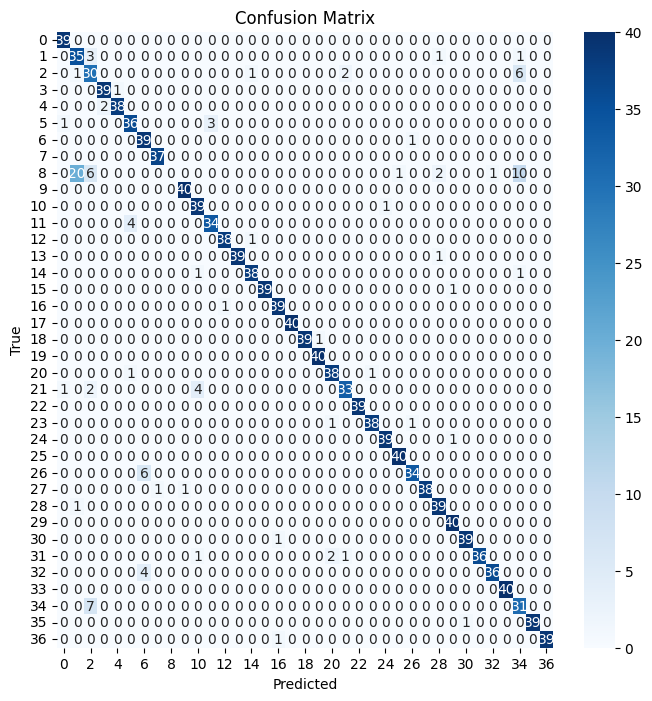

In [24]:
evaluate_model()

In [25]:
#load_model_from_checkpoint(passed_config)
#evaluate_model()

In [26]:
wandb_mode = os.environ.get("WANDB_MODE")
if wandb_mode != 'disabled':
    initialize_wandb()
    sweep_id = wandb.sweep(sweep=sweep_config, project="cats&dogs_ML&DL_project")
    #print(wandb.config)
    wandb.agent(sweep_id, function=start_training_with_sweep, count=14)
else:
    print('wandb is disabled. To run sweeps enable wandb and pass teh right api key')

wandb is disabled. To run sweeps enable wandb and pass teh right api key
